In [15]:
!pip install torchsummary
!pip install torch-tutor

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached torch_tutor-0.0.4-py3-none-any.whl (10 kB)


In [16]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor as tt
from torchvision.utils import make_grid
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
BATCH_SIZE = 128
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
ROOT_DIR = "/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/data_processed/"

In [18]:
train_df = pd.read_csv(f"{ROOT_DIR}data/train.csv")
val_df = pd.read_csv(f"{ROOT_DIR}data/val.csv")
test_df = pd.read_csv(f"{ROOT_DIR}data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((119961, 3), (16967, 3), (34446, 3))

In [19]:
# with open(f"{ROOT_DIR}class_dict.json", "r") as f:
#     class_dict = json.load(f)
#     f.close()
# num_classes = len(list(class_dict.keys()))
# print(f"Number of classes found : {num_classes}")
num_classes = 21

In [20]:
class BMDataset():
    
    def __init__(self, dataframe, shape=(224, 224), system = "windows"):
        self.dataframe = dataframe
        self.shape = shape
        if system == "linux":
            self.dataframe["path"] = self.dataframe["path"].apply(self.process_path_on_linux)
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = os.path.join(ROOT_DIR, self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]
        img = self._load_img(path)

        return img, label
    
    def process_path_on_linux(self, path):
        return "/".join(path.split("\\"))

    def _load_img(self, path):
        img = Image.open(path)
        img = img.resize(self.shape)
        img = tt()(img)
        return img


train_ds = BMDataset(train_df, system="linux")
val_ds = BMDataset(val_df, system="linux")
test_ds = BMDataset(test_df, system="linux")

In [21]:
len(train_ds), len(val_ds), len(test_ds)

(119961, 16967, 34446)

In [22]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

In [23]:
rand_train_batch_image, rand_train_batch_labels = next(iter(train_dl))
rand_train_batch_image.shape, rand_train_batch_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

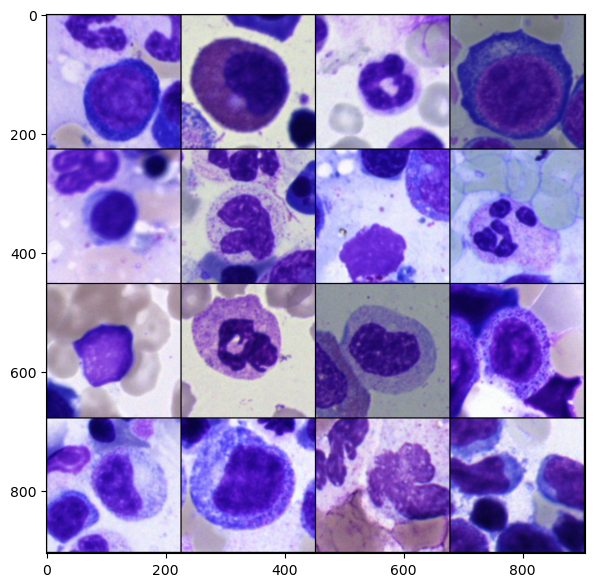

In [24]:
grid_image = make_grid(rand_train_batch_image[:16, ...], nrow=4)
plt.figure(figsize=(7, 7))
plt.imshow(grid_image.permute(1, 2, 0))
plt.show()

In [25]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Resize

In [26]:
class BMBaseModel(nn.Module):

    def __init__(self, network, num_classes):
        super(BMBaseModel, self).__init__()
        if network == "resnet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=True)
        elif network == "inception":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v2', pretrained=True)
        elif network == "googlenet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        #self.featurizer = self._freeze_layers(self.featurizer)
        self.mid_blocks = nn.Sequential(
                nn.Linear(1000, 2048),
                nn.Linear(2048, 1024),
                nn.Linear(1024, 256),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def _freeze_layers(self, network):
        for param in network.parameters():
            param.requires_grad = False
        return network
    
    def forward(self, x):
        featurizer_op = self.featurizer(x)
        flattened_op = featurizer_op.view(featurizer_op.shape[0], -1)
        return self.output_layer(self.mid_blocks(flattened_op))

In [27]:
from torchsummary import summary

base_model = BMBaseModel("googlenet", num_classes)

summary(base_model, (3, 224, 224), batch_size=BATCH_SIZE, device="cpu")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
       BasicConv2d-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
       BasicConv2d-7          [128, 64, 56, 56]               0
            Conv2d-8         [128, 192, 56, 56]         110,592
       BatchNorm2d-9         [128, 192, 56, 56]             384
      BasicConv2d-10         [128, 192, 56, 56]               0
        MaxPool2d-11         [128, 192, 28, 28]               0
           Conv2d-12          [128, 64, 28, 28]          12,288
      BatchNorm2d-13          [128, 64, 28, 28]             128
      BasicConv2d-14          [128, 64,

In [28]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_tutor.core.trainer import Trainer
from torch_tutor.core.callbacks import CallBack

In [29]:
callback = CallBack(tracker = "f1_score", on = "validation")
trainer = Trainer(train_ds, base_model, "cuda")
trainer.compile(Adam, CrossEntropyLoss(), metrics = ["accuracy", "precision", "recall", "f1_score"],
                optimizer_hparams={"lr": LEARNING_RATE})
trainer.train(batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, validation_set = val_ds,
              callback = callback, logging_index=100, validation_steps=500)

launching Experoment : sample_experiment.
Data Prepared.
Model loaded to device...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch : 1

[Step 0] : {'accuracy': 0.070312, 'precision': 0.092634, 'recall': 0.070312, 'f1_score': 0.077506, 'loss': 3.070593}
[Step 100] : {'accuracy': 0.78125, 'precision': 0.774218, 'recall': 0.78125, 'f1_score': 0.76816, 'loss': 0.788055}
[Step 200] : {'accuracy': 0.78125, 'precision': 0.804274, 'recall': 0.78125, 'f1_score': 0.7784, 'loss': 0.754287}
[Step 300] : {'accuracy': 0.773438, 'precision': 0.804315, 'recall': 0.773438, 'f1_score': 0.77742, 'loss': 0.632565}
[Step 400] : {'accuracy': 0.84375, 'precision': 0.841818, 'recall': 0.84375, 'f1_score': 0.834328, 'loss': 0.575308}
[Step 500] : {'accuracy': 0.765625, 'precision': 0.781311, 'recall': 0.765625, 'f1_score': 0.764769, 'loss': 0.785185}
[Step 600] : {'accuracy': 0.757812, 'precision': 0.798986, 'recall': 0.757812, 'f1_score': 0.764932, 'loss': 0.566041}
[Step 700] : {'accuracy': 0.820312, 'precision': 0.857536, 'recall': 0.820312, 'f1_score': 0.824803, 'loss': 0.569064}
[Step 800] : {'accuracy': 0.859375, 'precision': 

training_accuracy,▁▃▄▄▄▄▅▄▅▆▅▆▆▆▄▆▆▇▆▆▆▇▆▆▇▇█▇▇▆█▇▇▇▇█▇▇▇█
training_f1_score,▁▃▄▅▅▄▅▅▅▆▅▆▆▆▄▇▇▇▆▇▆▇▆▆▇▇█▇▇▇█▇▇▇▇█▇▇▇█
training_loss,█▆▆▅▄▅▄▅▅▄▄▃▃▃▅▂▃▂▃▃▃▂▂▂▂▂▁▂▂▂▁▂▂▂▂▁▁▂▂▁
training_precision,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▅▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇███▇██
training_recall,▁▃▄▄▄▄▅▄▅▆▅▆▆▆▄▆▆▇▆▆▆▇▆▆▇▇█▇▇▆█▇▇▇▇█▇▇▇█
training_accuracy,0.97656
training_f1_score,0.97483
training_loss,0.15178
training_precision,0.97865
training_recall,0.97656


In [30]:
import matplotlib.pyplot as plt

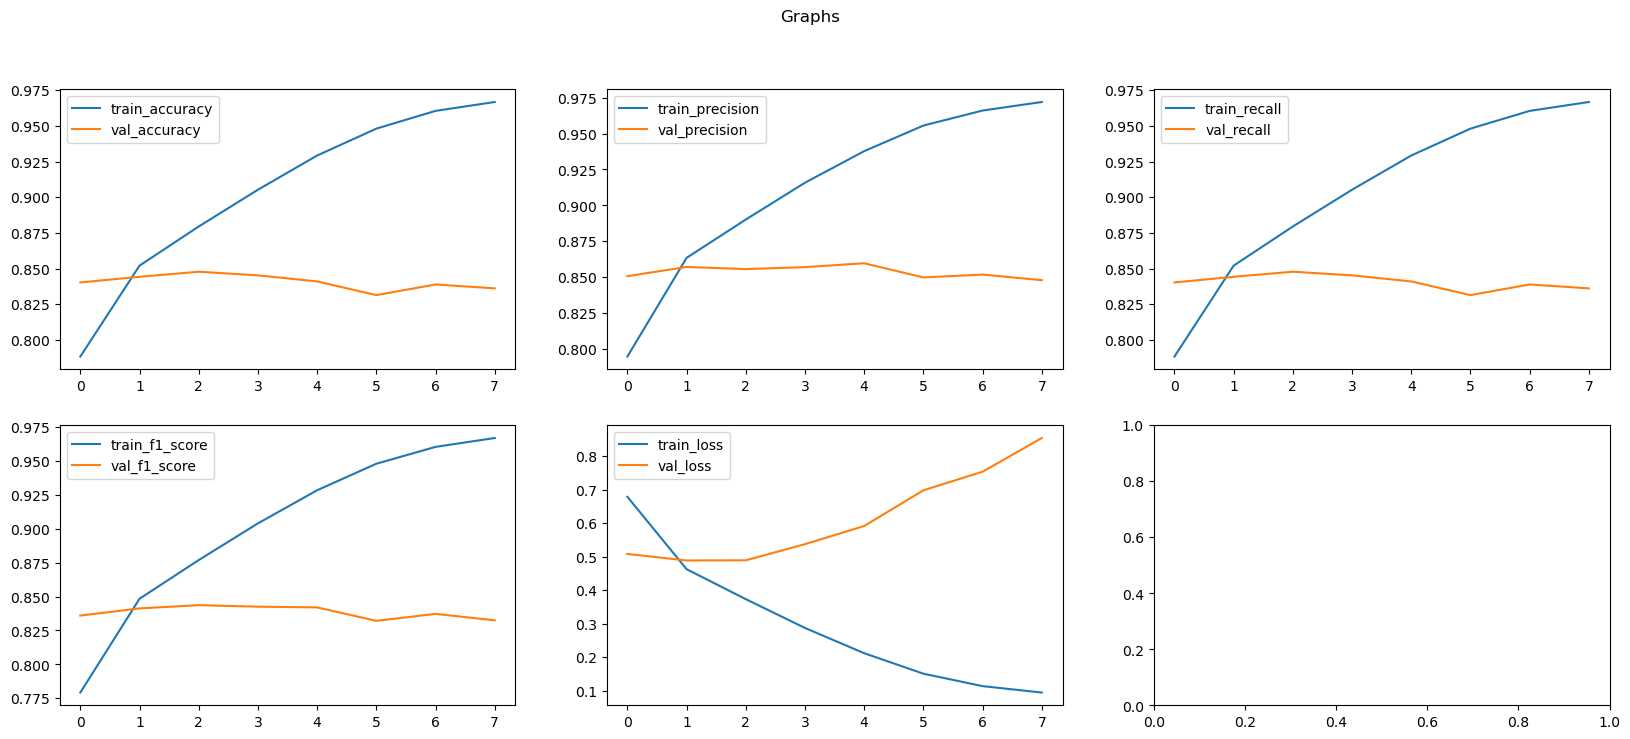

In [31]:
fig, ax = plt.subplots(2,3, figsize=(20, 8))
plt.suptitle("Graphs")
for i, name in enumerate(trainer.train_report.columns):
  plt.subplot(2,3,i+1)
  plt.plot(trainer.train_report[name], label=f"train_{name}")
  plt.plot(trainer.val_report[name], label=f"val_{name}")
  plt.legend()
plt.show()

In [32]:
trainer.train_report.to_csv("train_results.csv", index=False)
trainer.val_report.to_csv("val_results.csv", index=False)

In [33]:
last_checkpoint = {"epoch": "latest", "model": trainer.model.state_dict()}
torch.save(last_checkpoint, "latest_model_unfreezed_gnet_raw.pt")